## 神经网络实现翻译

- 参考链接 : https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

- 论文参考链接 : https://arxiv.org/abs/1409.3215

In this project we will be teaching a neural network to translate from French to English.

最终实现的目标如下

```python
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

### 主要思想

An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 数据预处理&读取数据

In [2]:
SOS_token = 0 # 句子开头
EOS_token = 1 # 句子结尾


class Lang:
    """word → index (word2index) and index → word (index2word) dictionaries
       A count of each word word2count to use to later replace rare words.
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
"""
 we will turn Unicode characters to ASCII, make everything lowercase, 
 and trim most punctuation.
"""

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
# 转换为 ASCII, 大写变小写, 留下重要的标点, 去掉大部分的标点
normalizeString('I am a Boy!~$%^&')

'i am a boy ! '

In [5]:
def readLangs(lang1, lang2, reverse=False):
    """逐行读取file, 并将每行分为pair, 并做标准化
    """
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

- 为了加快训练的速度, 我们把句子长度最大设置为10；
- 同时我们过滤句子后使得其开头变为如i am, he is等词汇

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# 会去掉单词个数超过 10 个的句子
# 会去掉不是以特定开头的句子
filterPairs([['i am a girl','i am a boy'],
             ['how are you','how are you'], # 不是特定开头的会被去掉
            ['i am a girl i am a girl i am a girl','i am a girl i am a girl']]) # 句子太长会被去掉

[['i am a girl', 'i am a boy']]

The full process for preparing the data is:

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [8]:
def prepareData(lang1, lang2, reverse=False):
    """开始读取语言的文件
    """
    # 读取文件, 返回的是句子对
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # 过滤掉句子对中较长的句子, 和
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
# 开始读取数据
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [10]:
# 随机选择一个数据对
print(random.choice(pairs))

['j ai peur des tremblements de terre .', 'i m afraid of earthquakes .']


In [11]:
print(output_lang.word2count.get('ok')) # 不同单词出现的次数
print(output_lang.word2index.get('ok')) # 每个单词的 index

10
5


将数据转换为 Tensor 数据。

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token) # 在句子末加入「结束符」
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## The Seq2Seq Model

### Seq2Seq的好处

对比传统的单层的RNN来说, 可以不需要输入和输出是相同的长度的. 

下面是完整的思想, 这里的原文还是很不错的.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne/pas” construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences.

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
    def forward(self, x):
        self.sentence_length = x.size(0) # 句子的长度
        embedded = self.embedding(x).view(self.sentence_length, 1, -1) # 转换为词向量
        self.hidden = self.initHidden()
        output, hidden = self.gru(embedded, self.hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device)

In [14]:
test_data = tensorsFromPair(random.choice(pairs))
test_data[0] # 句子对应的 index

tensor([[ 123],
        [ 126],
        [ 264],
        [ 270],
        [1396],
        [   5],
        [   1]], device='cuda:1')

In [15]:
# encoder测试
encoder1 = EncoderRNN(input_lang.n_words, 256).to(device)
output, hidden = encoder1(test_data[0].unsqueeze(1))
print(output.shape) # shape, [seq_len, batch, ]
print(hidden.shape) # 这里的 hidden state 包含整个文本的信息

torch.Size([7, 1, 256])
torch.Size([1, 1, 256])


### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden_state):
        # 这里的 hidden_state 需要传入, 传入的是 encoder 最后输出的那个向量
        self.hidden = hidden_state
        
        # 只能预测一个, 输入下一个
        embedded = self.embedding(x).view(1,1,-1) # 计算当前词汇的词向量
        output, hidden = self.gru(embedded, self.hidden)
        output = self.out(output[0]) # 从 hidden size 转换为 output size
        output = self.softmax(output) # output 是每个单词的概率
        return output, hidden

In [17]:
test_data = torch.tensor([[SOS_token]]).to(device) # 测试词汇
# output_lang.n_words = 2803
# output 的单词数量有 2803 个
decoder1 = DecoderRNN(256, output_lang.n_words).to(device)
output, hidden = decoder1(test_data, hidden)
print(output.shape)
print(hidden.shape) # 这个 hidden 会传入下一个

torch.Size([1, 2803])
torch.Size([1, 1, 256])


In [18]:
# 返回output最大值的位置
output.data.topk(1)

torch.return_types.topk(
values=tensor([[-7.3610]], device='cuda:1'),
indices=tensor([[2590]], device='cuda:1'))

## Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

### Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.(总体训练流程)



In [19]:
# helper function
import time
import math


def asMinutes(s):
    """将秒转换为分钟
    """
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """打印已经花费的时间和预计花费的时间
       预计花费的时间, 用 完成百分比的时间/现在完成的百分比 来预测
    """
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [20]:
teacher_forcing_ratio = 0.5 # 50% 的概率使用teacher_forcing的模式

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0) # 输入句子的长度
    target_length = target_tensor.size(0) # 翻译后句子长度
    
    
    # Encoder
    encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
    
    # Decoder
    loss = 0
    decoder_hidden = encoder_hidden
    decoder_input = torch.tensor([[SOS_token]]).to(device) # 初始
    # 判断是使用哪一种模式
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss = loss + criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # Teacher Forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            loss = loss + criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    # 反向传播, 进行优化
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

The whole training process looks like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [21]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    # 初始化优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # 初始化样本
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total = print_loss_total + loss
        plot_loss_total = plot_loss_total + loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Ploting results

In [22]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure(figsize=(14,7))
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Start Training

0m 12s (- 41m 23s) (500 0%) 3.8136
0m 16s (- 27m 23s) (1000 1%) 3.3396
0m 20s (- 22m 42s) (1500 1%) 3.0684
0m 24s (- 20m 18s) (2000 2%) 2.8777
0m 29s (- 19m 20s) (2500 2%) 2.8013
0m 34s (- 18m 32s) (3000 3%) 2.7315
0m 39s (- 17m 58s) (3500 3%) 2.7058
0m 43s (- 17m 32s) (4000 4%) 2.7262
0m 48s (- 17m 10s) (4500 4%) 2.5931
0m 53s (- 16m 52s) (5000 5%) 2.5762
0m 57s (- 16m 34s) (5500 5%) 2.4469
1m 2s (- 16m 24s) (6000 6%) 2.5235
1m 7s (- 16m 12s) (6500 6%) 2.4508
1m 12s (- 16m 0s) (7000 7%) 2.3647
1m 16s (- 15m 48s) (7500 7%) 2.3632
1m 21s (- 15m 39s) (8000 8%) 2.3667
1m 26s (- 15m 30s) (8500 8%) 2.2198
1m 31s (- 15m 22s) (9000 9%) 2.3303
1m 35s (- 15m 14s) (9500 9%) 2.2158
1m 40s (- 15m 4s) (10000 10%) 2.1126
1m 44s (- 14m 53s) (10500 10%) 2.1817
1m 49s (- 14m 43s) (11000 11%) 2.2011
1m 53s (- 14m 33s) (11500 11%) 2.0906
1m 57s (- 14m 23s) (12000 12%) 2.0148
2m 1s (- 14m 13s) (12500 12%) 1.9921
2m 6s (- 14m 5s) (13000 13%) 2.0641
2m 10s (- 13m 56s) (13500 13%) 1.9693
2m 14s (- 13m 48s) (

<Figure size 1008x504 with 0 Axes>

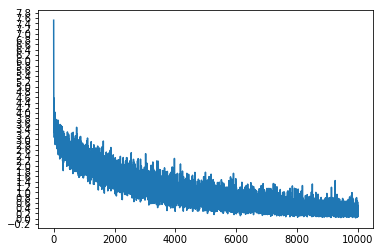

In [23]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, n_iters=100000, print_every=500, plot_every=10)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [27]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        # Encoder
        encoder_output, encoder_hidden = encoder1(input_tensor.unsqueeze(1))
        
        # Decoder
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden  )
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                """遇到终止符就停止
                """
                decoded_words.append('<EOS>')
                break
            else:
                """把decode的word加入数组中
                """
                decoded_words.append(output_lang.index2word[topi.item()])
                
            # 下一个的输入是上一个的输出
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1]) # 真实句子
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [29]:
evaluateRandomly(encoder1, decoder1, n=70)

> j ai peur qu il commette une erreur .
= i am afraid he will make a mistake .
< i am afraid he will make a mistake . <EOS>

> je suis reellement fier de vous .
= i m really proud of you .
< i m really proud of you . <EOS>

> tu ne trompes personne .
= you re not fooling anybody .
< you re not fooling anybody . <EOS>

> je suis un garcon timide .
= i am a shy boy .
< i am a shy boy . <EOS>

> je suis satisfaite de leur prestation .
= i m pleased with their performance .
< i m pleased with their performance . <EOS>

> tu ne vas pas le croire .
= you re not going to believe this .
< you re not going to believe this . <EOS>

> vous n etes pas fatigue si ?
= you re not tired are you ?
< you re not tired are you ? <EOS>

> je suis satisfaite de leur performance .
= i m pleased with their performance .
< i m pleased with their performance . <EOS>

> je suis maladroit .
= i m all thumbs .
< i m all with . <EOS>

> je suis vraiment desole .
= i am very sorry .
< i am very sorry . <EOS>

> nous

### 存在的问题

- 要是输入的句子很长，我们的 Encoder 会记不住完整的句子。
- 要是输入里的一些词被忘记了，那么 Decoder 就无法得知完整的句子，就无法产生正确的结果。
- 如果不使用 Attention 机制，超过 20 个单词就会出现遗忘。